In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import bessel, lfilter, welch

Goertzel reference: <br> https://www.embedded.com/the-goertzel-algorithm/ <br>
https://www.dsp-weimich.com/digital-signal-processing/goertzel-algorithm-and-c-implementation-using-the-octave-gnu-tool/

In [15]:
# Goertzel algorithm function
def goertzel(samples, sample_rate, target_freq, n):
    """
    The Goertzel algorithm is used to calculate the magnitude of a specific frequency component within a signal.
    This is particularly efficient for computing the spectral content at specific frequencies of interest.
    """
    k = int(0.5 + n * target_freq / sample_rate)
    omega = (2 * np.pi / n) * k
    coeff = 2 * np.cos(omega)
    q0, q1, q2 = 0, 0, 0
    for sample in samples:
        q0 = coeff * q1 - q2 + sample
        q2 = q1
        q1 = q0
    real = (q1 - q2 * np.cos(omega))
    imag = (q2 * np.sin(omega))
    return np.sqrt(real**2 + imag**2)

# Function to calculate magnitude response over a range of frequencies
def magnitude_response(signal, sample_rate, freq_range, n):
    magnitudes = []
    for freq in freq_range:
        magnitude = goertzel(signal, sample_rate, freq, n)
        magnitudes.append(magnitude)
    return magnitudes

# Function to apply a 4th order Bessel filter
def apply_bessel_filter(signal, sample_rate, cutoff_freq):
    """
    This function applies a 4th order Bessel filter to the signal.
    The Bessel filter is known for its linear phase response but has a gentler roll-off compared to other filters.
    The cutoff frequency determines the frequency point at which the filter starts attenuating the signal.
    """
    b, a = bessel(N=4, Wn=cutoff_freq/(0.5*sample_rate), btype='low', analog=False)
    return lfilter(b, a, signal)

def calculate_psd_rfu(signal, sample_rate, center_freq, bandwidth):
    """
    This function calculates the Power Spectral Density (PSD) and Relative Field Unit (RFU) of the signal.
    PSD provides a measure of the signal's power content versus frequency.
    RFU is calculated as the sum of PSD values within a specified frequency range, indicating the signal's strength in that range.
    """
    f, Pxx = welch(signal, fs=sample_rate, nperseg=1024)
    # Find the frequency range of interest
    freq_range = (f >= center_freq - bandwidth/2) & (f <= center_freq + bandwidth/2)
    # Isolate the PSD values within the frequency range of interest
    Pxx_interest = Pxx[freq_range]
    f_interest = f[freq_range]
    # Calculate RFU as the sum of PSD in the frequency range of interest
    rfu = np.sum(Pxx_interest)
    return f_interest, Pxx_interest, rfu

# Function to add white Gaussian noise to a signal
def add_white_noise(signal, noise_level):
    """
    This function adds white Gaussian noise to the signal.
    The noise level is a fraction of the signal's standard deviation, allowing control over the signal-to-noise ratio.
    Adding noise can be useful for testing the robustness of signal processing algorithms.
    """
    mean_noise = 0
    std_noise = noise_level * np.std(signal)
    noise = np.random.normal(mean_noise, std_noise, len(signal))
    return signal + noise


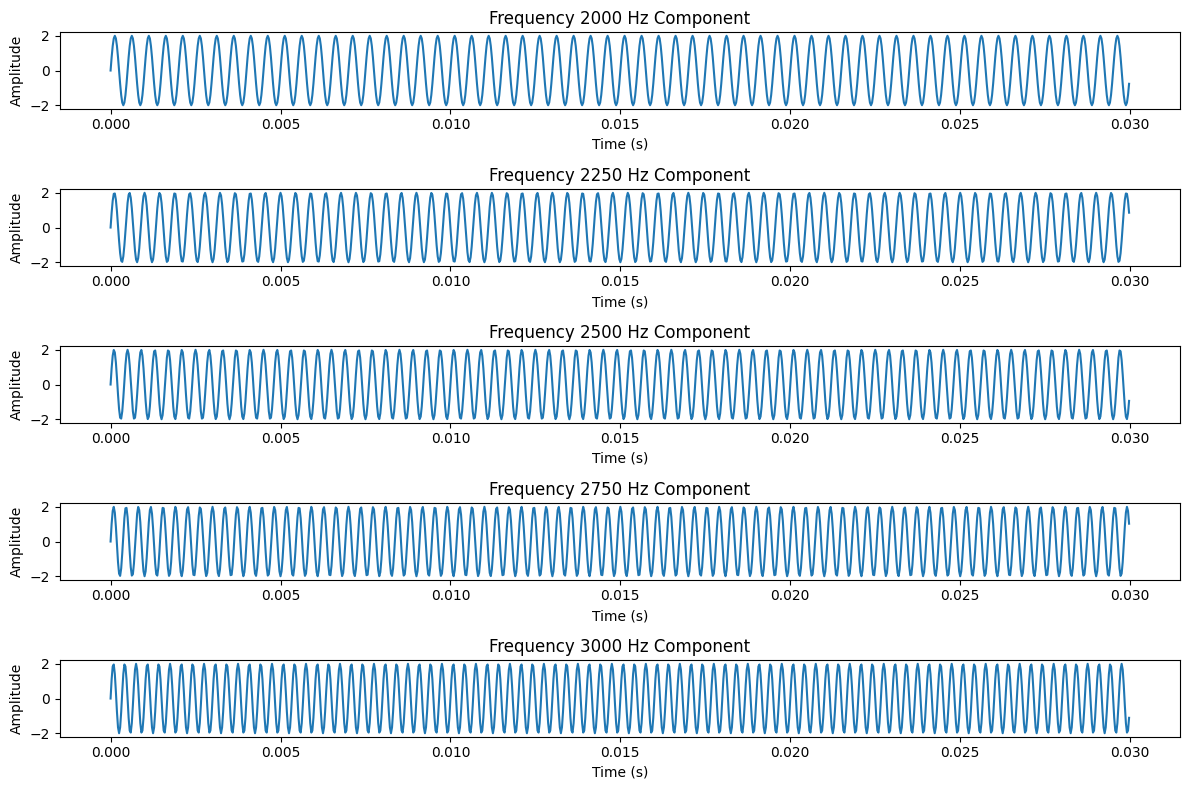

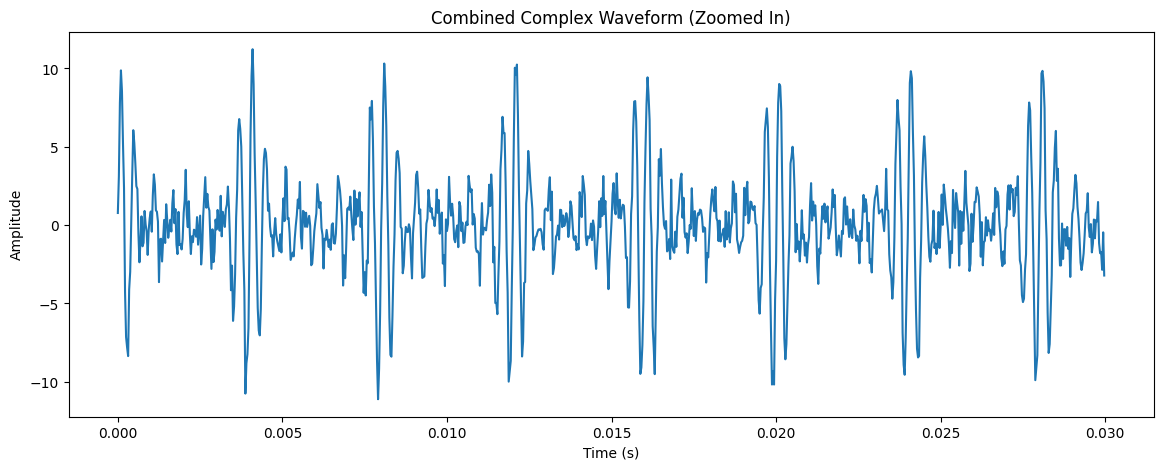

In [16]:

# Noise level as a fraction of the signal's standard deviation
noise_level = 0.3  # Adjust this to increase or decrease noise level

# Signal parameters
sampling_rate = 32000  # Hz
duration = 1           # seconds
frequencies = [2000, 2250, 2500, 2750, 3000]  # Hz
amplitude = 2.0  # Amplitude factor

# Time array
t = np.arange(0, duration, 1 / sampling_rate)

signals = [amplitude * np.sin(2 * np.pi * f * t) for f in frequencies]

# Plotting parameters
plot_duration = 0.03  # seconds to display in the plot
samples_to_plot = int(sampling_rate * plot_duration)

plt.figure(figsize=(12, 8))
# Plot each frequency component within a smaller time window
for i, signal in enumerate(signals):
    plt.subplot(len(frequencies), 1, i + 1)
    plt.plot(t[:samples_to_plot], signal[:samples_to_plot])
    plt.title(f"Frequency {frequencies[i]} Hz Component")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.tight_layout()

plt.show()

# Combining signals
combined_signal = np.sum(signals, axis=0)
combined_signal = add_white_noise(combined_signal, noise_level)  # un-comment this line to inject noise

# Plotting the combined signal within the same smaller time window
plt.figure(figsize=(14, 5))
plt.plot(t[:samples_to_plot], combined_signal[:samples_to_plot])
plt.title("Combined Complex Waveform (Zoomed In)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

Frequency 2000 Hz, Magnitude: 17231.912460606327
Frequency 2250 Hz, Magnitude: 17252.606877257353
Frequency 2500 Hz, Magnitude: 17244.739787241375
Frequency 2750 Hz, Magnitude: 17268.99478510328
Frequency 3000 Hz, Magnitude: 17411.55258240176


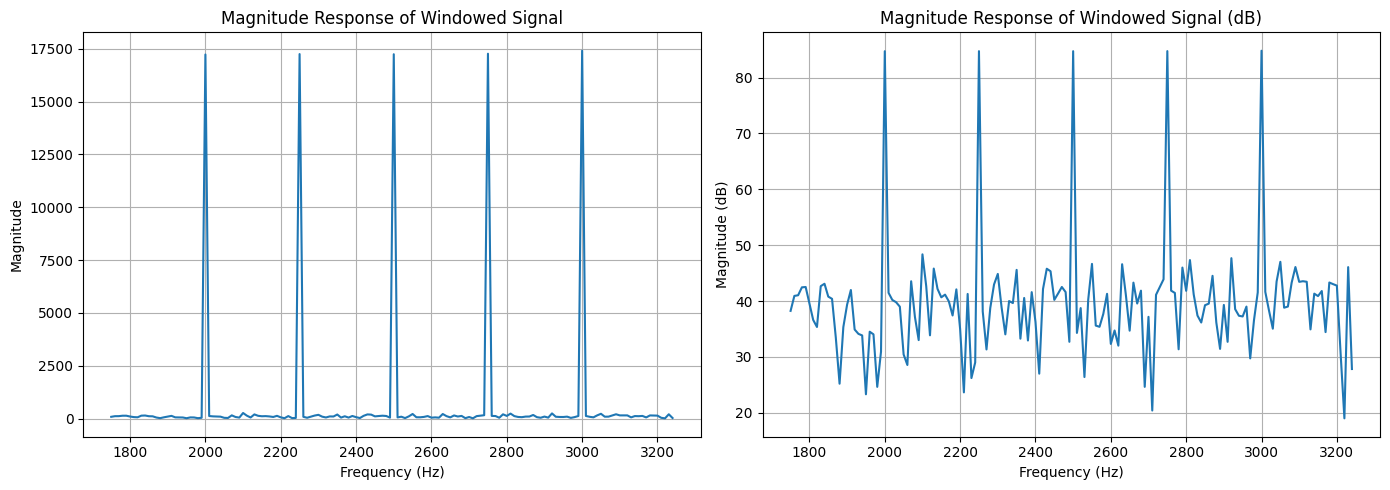

In [20]:
# Apply Bessel filter
cutoff_frequency = 0.05 * sampling_rate  # Normalized cutoff frequency
filtered_signal = combined_signal
# filtered_signal = apply_bessel_filter(combined_signal, sampling_rate, cutoff_frequency)

# Apply Hamming window to the filtered signal
windowed_signal = filtered_signal * np.hamming(len(filtered_signal))

# Applying the Goertzel algorithm to the windowed signal
n = len(windowed_signal)
results = {f: goertzel(windowed_signal, sampling_rate, f, n) for f in frequencies}

# Displaying the results
for f, magnitude in results.items():
    print(f"Frequency {f} Hz, Magnitude: {magnitude}")

# Define frequency range for the magnitude response
freq_start = 1750  # Start frequency in Hz
freq_end = 3250    # End frequency in Hz
freq_step = 10     # Frequency step in Hz
frequency_range = np.arange(freq_start, freq_end, freq_step)

# Calculate magnitude response of the windowed signal
n = len(windowed_signal)
magnitudes = magnitude_response(windowed_signal, sampling_rate, frequency_range, n)

# Convert magnitudes to decibels
magnitudes_db = 20 * np.log10(magnitudes)

# Plotting setup
plt.figure(figsize=(14, 5))


# Linear scale
plt.subplot(1, 2, 1)
plt.plot(frequency_range, magnitudes)
plt.title("Magnitude Response of Windowed Signal")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.grid(True)

# dB scale
plt.subplot(1, 2, 2)
plt.plot(frequency_range, magnitudes_db)
plt.title("Magnitude Response of Windowed Signal (dB)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.grid(True)

plt.tight_layout()
plt.show()


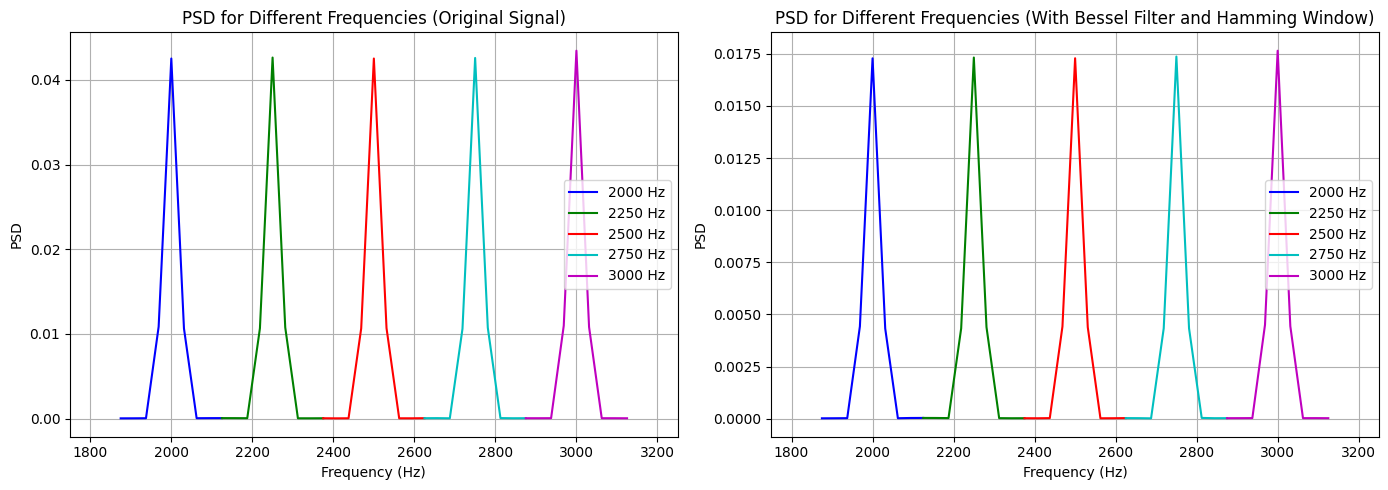

In [21]:
# Frequencies of interest and padding
frequencies_of_interest = frequencies
padding = 250  # Hz

# Plotting setup
plt.figure(figsize=(14, 5))
colors = ['b', 'g', 'r', 'c', 'm']  # Different color for each frequency plot
# Plot PSD with Bessel filter and Hamming window
plt.plot
for i, center_frequency in enumerate(frequencies_of_interest):
    freqs, psd, _ = calculate_psd_rfu(windowed_signal, sampling_rate, center_frequency, padding)
    plt.plot(freqs, psd, label=f'{center_frequency} Hz', color=colors[i % len(colors)])
plt.title("PSD for Different Frequencies (With Bessel Filter and Hamming Window)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD")
plt.xlim(min(frequencies_of_interest) - padding, max(frequencies_of_interest) + padding)
plt.legend()
plt.grid(True)

# Show the plots
plt.tight_layout()
plt.show()


1600.0


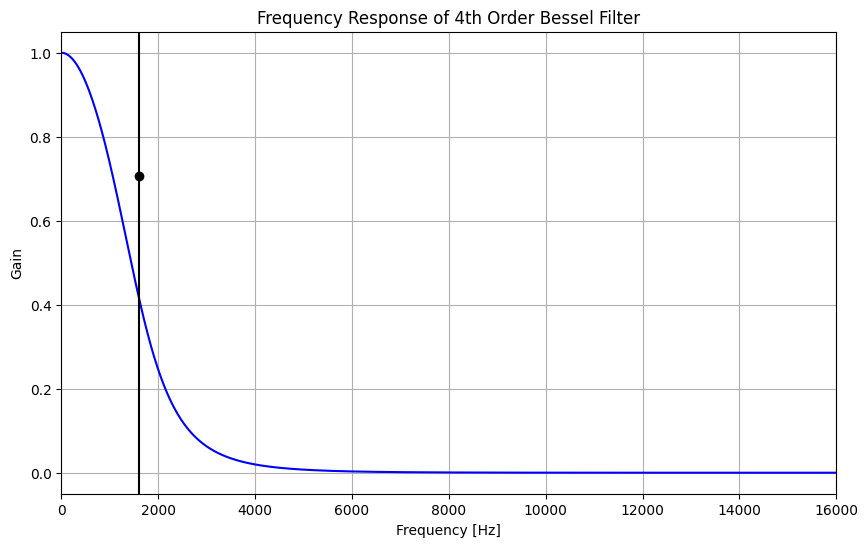

In [19]:
from scipy.signal import freqz

"""
The plot shows how the filter attenuates frequencies above the cutoff frequency. 
The Bessel filter is characterized by a smooth transition from the passband to the stopband, 
and the plot illustrates this with a gradual roll-off in gain beyond the cutoff frequency.
The gain at the cutoff frequency is typically 0.707 (or -3dB), which is a standard reference point for filter design.
"""

# Define the Bessel filter parameters
b, a = bessel(N=4, Wn=cutoff_frequency/(0.5*sampling_rate), btype='low', analog=False)

# Compute the frequency response
w, h = freqz(b, a, worN=8000)

# Plot the frequency response
plt.figure(figsize=(10, 6))
plt.plot(0.5 * sampling_rate * w / np.pi, np.abs(h), 'b')
plt.plot(cutoff_frequency, 0.5*np.sqrt(2), 'ko')
print(cutoff_frequency)
plt.axvline(cutoff_frequency, color='k')
plt.xlim(0, 0.5 * sampling_rate)
plt.title("Frequency Response of 4th Order Bessel Filter")
plt.xlabel('Frequency [Hz]')
plt.ylabel('Gain')
plt.grid()
plt.show()